# Transaction's forecast
## Fintech Client Transaction Forecasting Challenge
### NOUHAILA DRAIDAR <nouhailadraidar1@gmail.com>

## Importing Dependencies & Dataset

In [402]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [702]:
df = pd.read_csv("train_test_data.csv")
df.head()

,Date,Id_compte,amount_transaction,category_transaction
0,2022-01-01 00:23:00,SEWC_CL.1,462.96,Food & Drink - Groceries
1,2022-01-01 00:26:00,SEW0C_LI.1,15.51,General Services - Home Repair + Maintenance
2,2022-01-01 01:01:00,US.1,2.24,Bank Transfers - ATM withdrawals
3,2022-01-01 01:21:00,TA.1,2.86,Transportation - Public Transport
4,2022-01-01 01:54:00,US.1,1.68,Bank Transfers - ATM withdrawals


## EDA : Exploratory Data Analysis

Let's start with some basic informations about our dataset: The shape, statistical informations about our numerical column and null values

In [404]:
df.shape

(20411, 4)

In [405]:
df.describe()

,amount_transaction
count,20411.000000
mean,56.955119
std,150.401661
min,0.230000
25%,2.790000
50%,4.700000
75%,8.790000
max,2005.200000


In [406]:
# Is there any null values?
df.isnull().sum()

Date                    0
Id_compte               0
amount_transaction      0
category_transaction    0
dtype: int64

#### What is the min transactions amount?

In [407]:
df['amount_transaction'].min()

0.23

#### What is the max transactions amount?

In [408]:
df['amount_transaction'].max()

2005.2

#### What are the ID of the accounts that make transactions?

In [409]:
df["Id_compte"].unique()

array(['SEWC_CL.1', 'SEW0C_LI.1', 'US.1', 'TA.1', 'HP.1', 'CPA_MP.1',
       'SEW0C_HI.1', 'IPA.1', 'CPA.1', 'SEWC_P_PL.1', 'SEWC_PA.1',
       'SEWC_P.1'], dtype=object)

#### What is the total transactions amount by account?

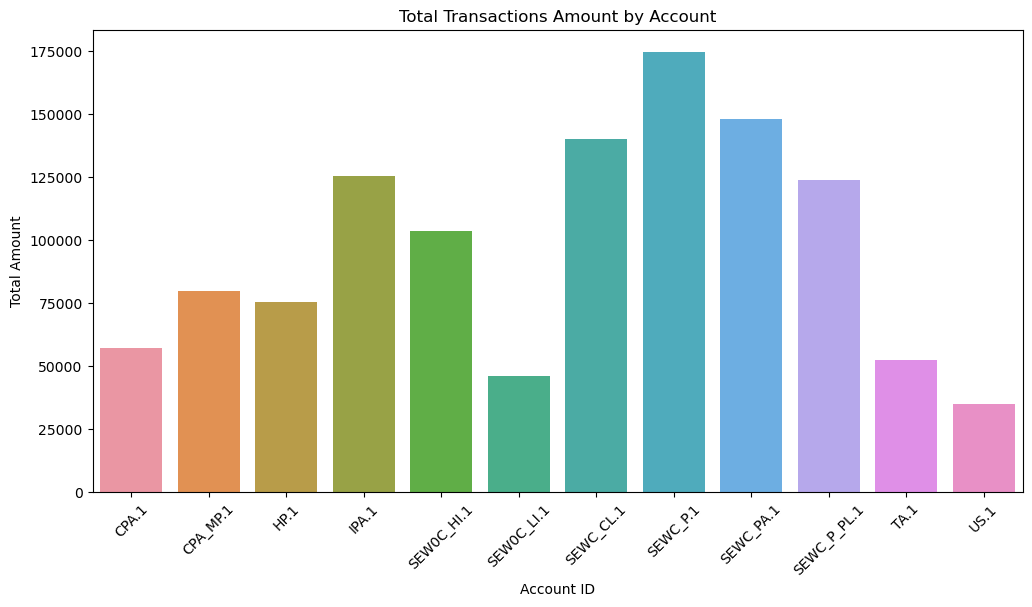

In [410]:
total_amount_by_account = df.groupby("Id_compte")["amount_transaction"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Id_compte', y='amount_transaction', data=total_amount_by_account)
plt.title('Total Transactions Amount by Account')
plt.xlabel('Account ID')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.show()

#### Distribution of transaction amounts

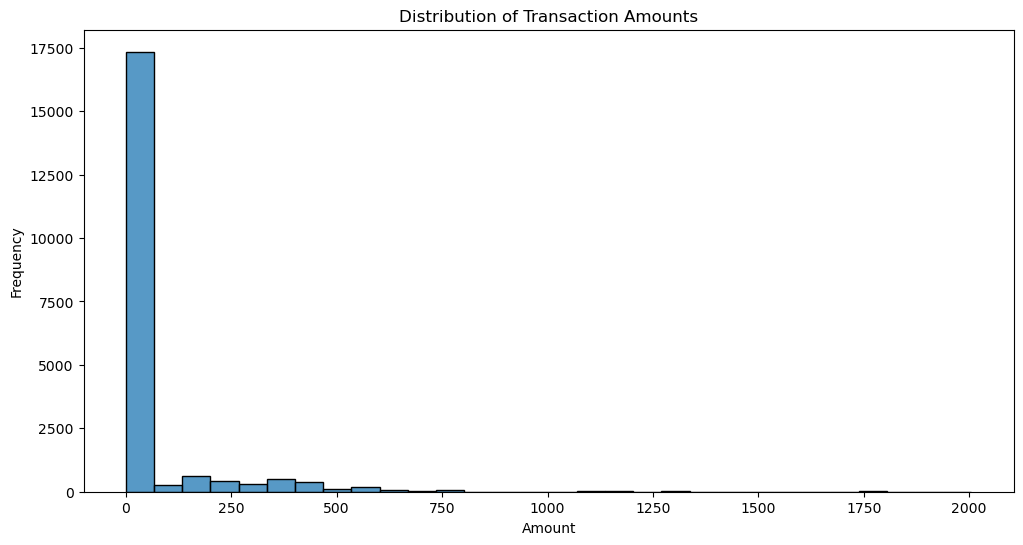

In [411]:
plt.figure(figsize=(12, 6))
sns.histplot(df['amount_transaction'], bins=30)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show() 

#### Time series plot of transaction amounts over time

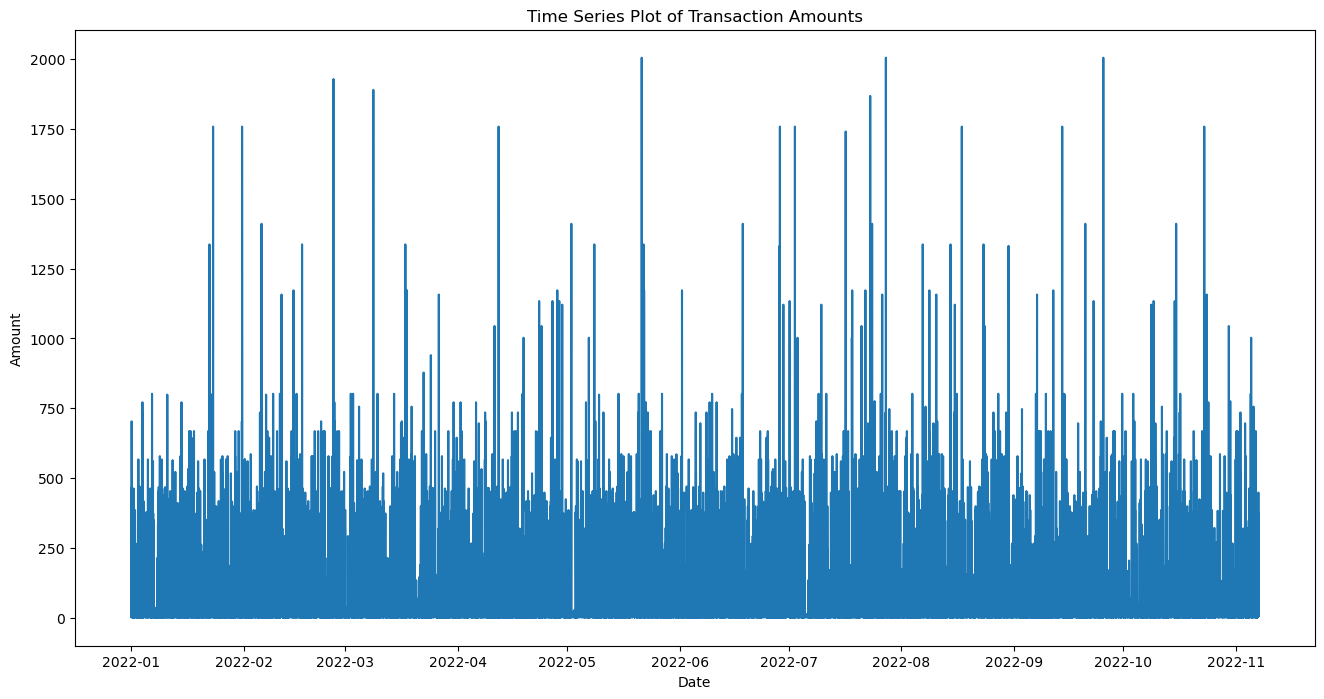

In [412]:
plt.figure(figsize=(16, 8))
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['amount_transaction'])
plt.title('Time Series Plot of Transaction Amounts')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.show()

Let's improve the visibility in our graphics and the quality of the visualization with feature engineering.

### Feature engineering

#### Transaction features
Let's create columns with the daily number of transactions by Id_compte , and the daily total of transactions by Id_compte.

In [413]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
Nbr_transactions = df.groupby('Date')['amount_transaction'].count().reset_index()
Total_transactions= df.groupby('Date')['amount_transaction'].sum().reset_index()

# merge the two columns in one new dataframe
df_transaction = pd.merge(Nbr_transactions, Total_transactions, on='Date')
print(df_transaction.shape)
df_transaction.head()

(311, 3)


,Date,amount_transaction_x,amount_transaction_y
0,2022-01-01,59,2907.32
1,2022-01-02,60,1100.87
2,2022-01-03,70,5192.62
3,2022-01-04,51,3547.83
4,2022-01-05,51,2992.66


In [414]:
# rename of the columns
df_transaction.rename(columns={'amount_transaction_x': 'Nbr_transaction', 'amount_transaction_y': 'Total_transaction'}, inplace=True)
df_transaction.head(1)

,Date,Nbr_transaction,Total_transaction
0,2022-01-01,59,2907.32


In [415]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 0 to 310
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               311 non-null    object 
 1   Nbr_transaction    311 non-null    int64  
 2   Total_transaction  311 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.7+ KB


We can see that the dataset contains a Date and Nbr_transaction and Total_transaction column.

Their data types are object and int64  and float64 respectively.

The important thing to note is that, the Date column must be of the datetime type. But, we can see that it is of object data type. So, we’ll need to convert it into datetime type.

In [416]:
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 0 to 310
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               311 non-null    datetime64[ns]
 1   Nbr_transaction    311 non-null    int64         
 2   Total_transaction  311 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 9.7 KB


**Time series plot of the new dataframe**

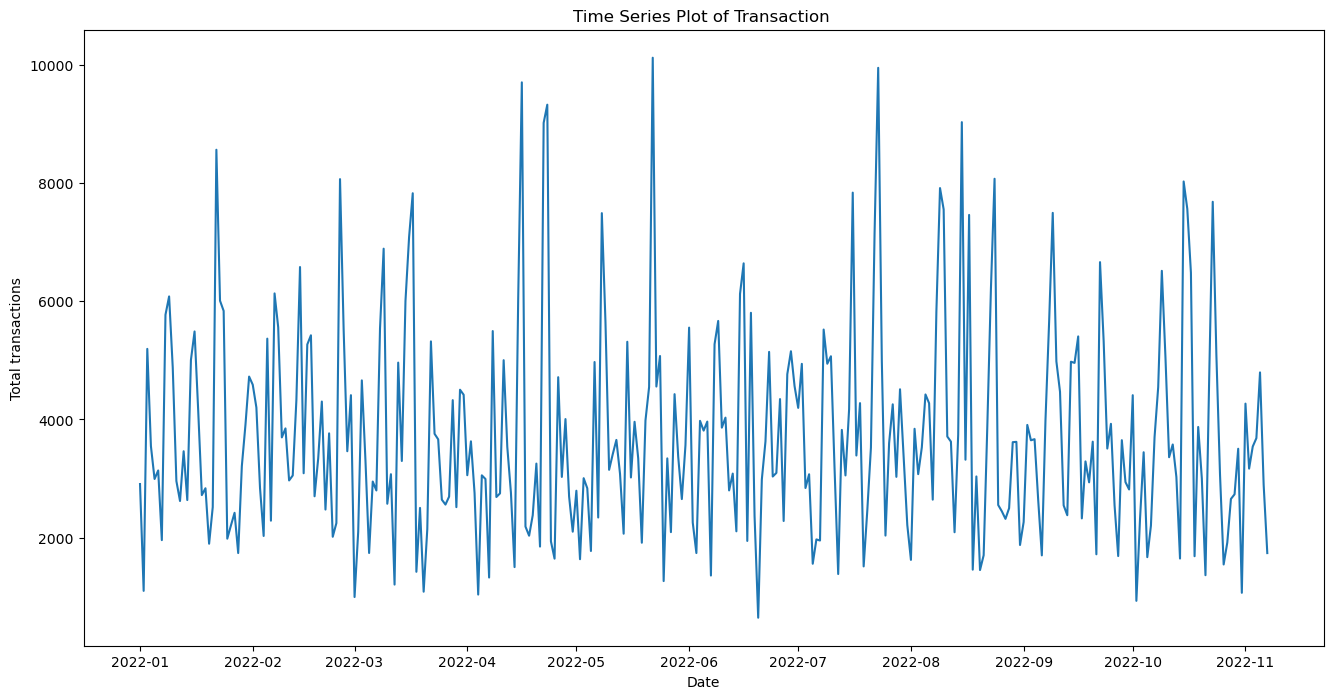

In [417]:
plt.figure(figsize=(16, 8))
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])
plt.plot(df_transaction['Date'], df_transaction['Total_transaction'])
plt.title('Time Series Plot of Transaction ')
plt.xlabel('Date')
plt.ylabel('Total transactions')
plt.show()

The time series plot of the new dataframe is easier to interpret.
The shape of the curve has an average and a nearly stable variable with no trend, so a normal regression model isn't a good fit for our problem here, it is quite poor when a series does not have a trend.
<br>
**So let's start with some statistical visualisations first**

In [418]:
# change the index to date for easier manipulation
df_transaction.index = df_transaction.Date
df_transaction = df_transaction.drop("Date", axis=1)

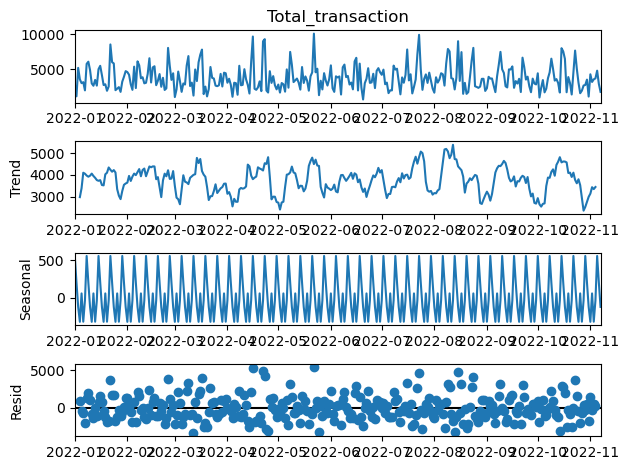

In [419]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df_transaction['Total_transaction'])
fig = results.plot()

In the 3rd visual, we observe a seasonal pattern in the shape of a **W** approximately 4 times each month, leading us to think that something might be up once a week.<br>
Let's investigate this more closely by visualizing the data one week at a time.

<AxesSubplot:xlabel='Date'>

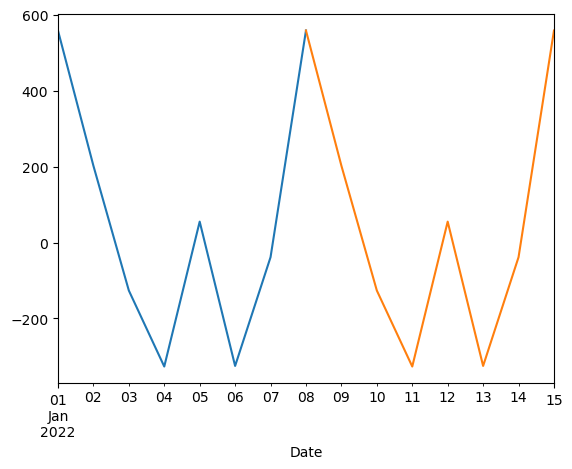

In [420]:
results.seasonal[date(2022,1,1):date(2022,1,8)].plot()
results.seasonal[date(2022,1,8):date(2022,1,15)].plot()

As we aprehended, there is a pattern every week:<br>
This pattern suggests significant fluctuations in transactions over 7days of the week, showing a decrease starting from 1st to 4th of january, then an increase on the 5th, and a decrease on the next day before an increase again to the 7th day. This may indicate specific trends or patterns in transaction behavior, such as increased activity at certain times of the week.
The 5/1/22 happens to be a wednesday, so the amount of transactions increase in the middle of the week, and increases again in the weekend (friday-saturday) after decreasing thursday.

### MODELIZATION

We choose Prophet as the first naive modelization.

The Prophet library expects as input a dataframe with one column containing the time information, and another column containing the metric that we wish to forecast, which are respectively Date and Total_transaction.

In [664]:
from datetime import date
test_df = df_transaction[date(2022,10,7):date(2022,11,7)]
train_df = df_transaction[date(2022,1,1):date(2022,10,7)]

In [665]:
print(train_df.shape,test_df.shape)

(280, 2) (32, 2)


22:47:39 - cmdstanpy - INFO - Chain [1] start processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing


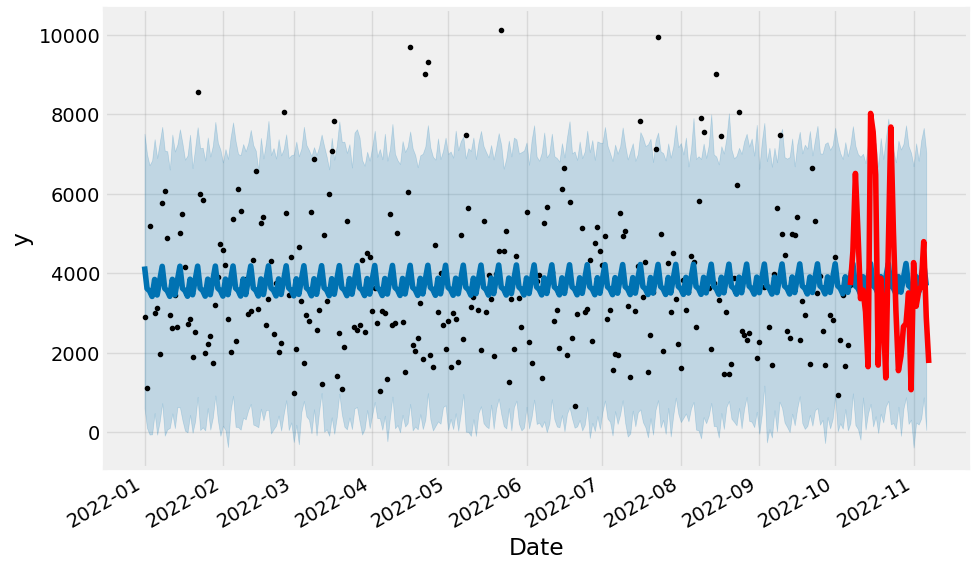

In [666]:
from prophet import Prophet

prophet_df = train_df.reset_index()
prophet_df = prophet_df[['Date', 'Total_transaction']].rename(columns={'Date': 'ds', 'Total_transaction': 'y'})

model = Prophet(interval_width=0.95)
model.fit(prophet_df)

#set the period of future dates to predict to 30 days
future = model.make_future_dataframe(periods=30)  
forecast = model.predict(future)

fig = model.plot(forecast, uncertainty=True)
fig = test_df['Total_transaction'].plot(color='red')


We notice that the model <span style="color: red;">(curve in red)</span> has very bad predictions compared with the test values<span style="color: blue;"> (blue)</span>

In [667]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_df['Total_transaction'],forecast.yhat[:32])
mse

3763806.889593636

In [668]:
import math
sqr = math.sqrt(mse)
sqr

1940.0533213274414

Absolutely not a good fit! Look at this MSE!

#### Time-Based Features
The goal of our analysis is to build a forecasting model that can predict the total daily transaction amounts. The **Date** column contains a lot of interesting details about the transaction, so let's extract the date only so we can group the transactions amount by day later.

In [647]:
def add_time_features(df, label=None):
    df['Date'] = df.index
    df['month'] = df['Date'].dt.month
    df['day_of_month'] = df['Date'].dt.day
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['week_of_year'] = df['Date'].dt.isocalendar().week  
    df['day_of_week'] = df['Date'].dt.dayofweek
    df["is_weekend"] = df['Date'].dt.weekday // 4
    df['quarter'] = df['Date'].dt.quarter
    df['is_weekday'] = (df['Date'].dt.weekday < 5).astype(int)  
    
    df['week_of_year'] = df['week_of_year'].astype(int)
    
    X = df[['month','day_of_month','day_of_year','week_of_year','day_of_week',
           'is_weekend','quarter','is_weekday', 'Total_transaction']]
    if label:
        y = df[label]
        return X, y
    return X

In [640]:
# split data
split_date = '2022-10-07'
df_train = df_transaction['Total_transaction'].loc[df_transaction.index <= split_date].copy()
df_test = df_transaction['Total_transaction'].loc[df_transaction.index > split_date].copy()
df_test = pd.DataFrame(df_test)
df_train = pd.DataFrame(df_train)
print(df_train.shape, df_test.shape)

(280, 1) (31, 1)


In [648]:
# Apply the function on our training and testing sets
X_train, y_train = add_time_features(df_train, label='Total_transaction')
X_test, y_test = add_time_features(df_test, label='Total_transaction')

In the case where we know the country/city of the transactions, we could also consider adding features like holiday days to understand if some transactions amounts are higher or lower due to holidays.

In [203]:
#df_transaction['is_holiday'] = df_transaction['Date'].isin(holiday_dates).astype(int)

### SECOND MODEL : XGBoost

In [638]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

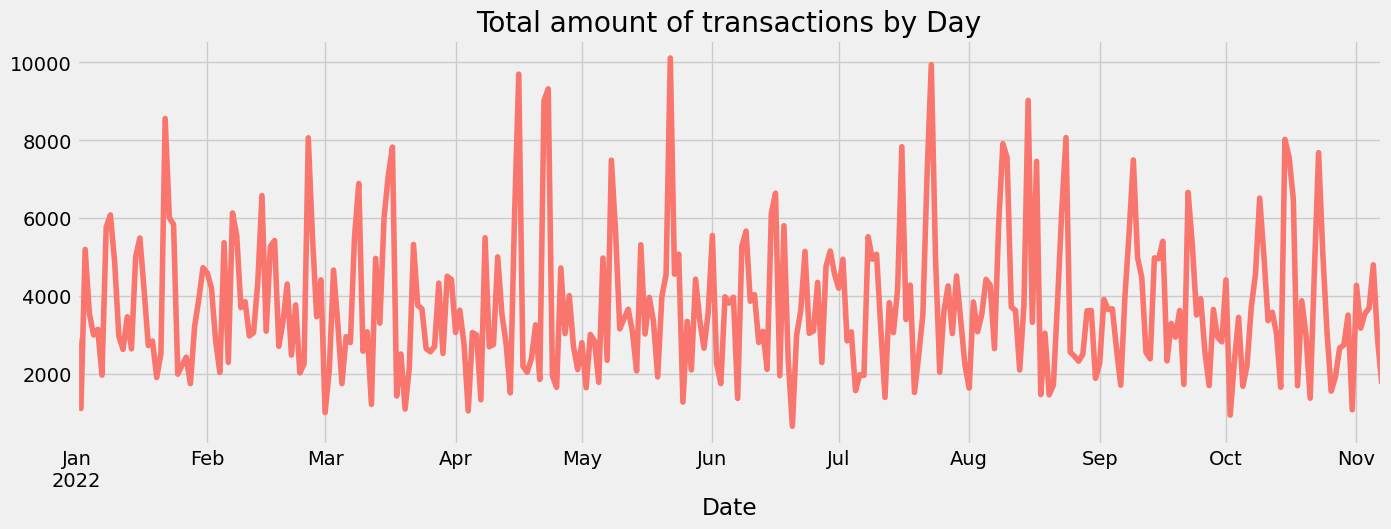

In [803]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df_transaction['Total_transaction'].plot(style='', figsize=(15,5), color=color_pal[0], title='Total amount of transactions by Day')

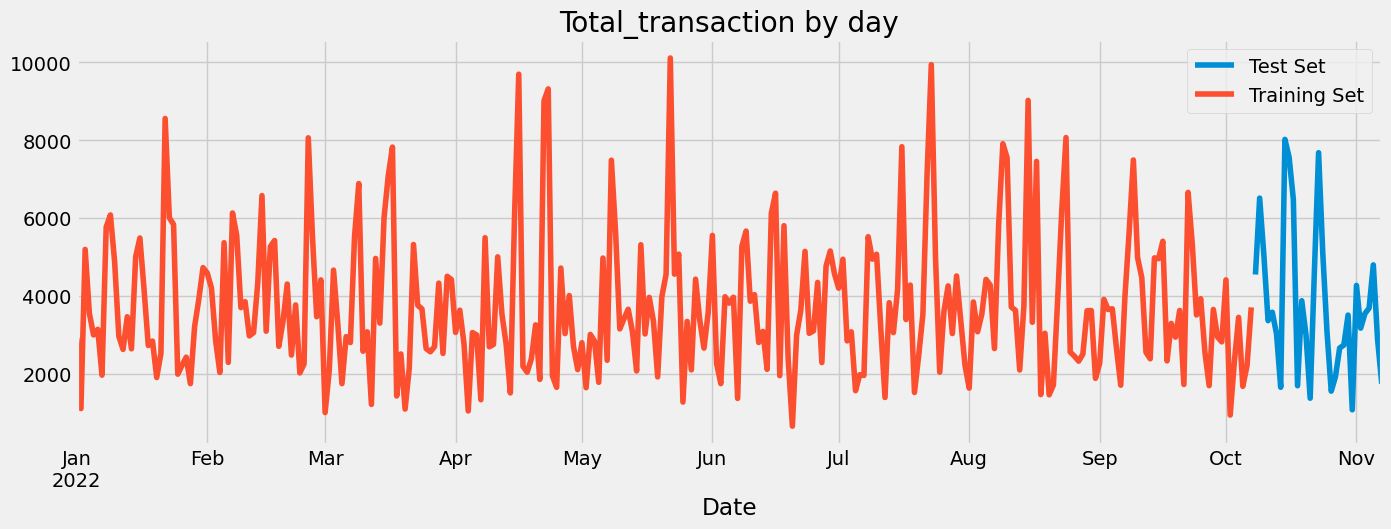

In [641]:
_ = df_test \
    .rename(columns={'Total_transaction': 'Test Set'}) \
    .join(df_train.rename(columns={'Total_transaction': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='Total_transaction by day', style='')

In [649]:
X_train

,month,day_of_month,day_of_year,week_of_year,day_of_week,is_weekend,quarter,is_weekday,Total_transaction
Date,,,,,,,,,
2022-01-01,1,1,1,52,5,1,1,0,2907.32
2022-01-02,1,2,2,52,6,1,1,0,1100.87
2022-01-03,1,3,3,1,0,0,1,1,5192.62
2022-01-04,1,4,4,1,1,0,1,1,3547.83
2022-01-05,1,5,5,1,2,0,1,1,2992.66
...,...,...,...,...,...,...,...,...,...
2022-10-03,10,3,276,40,0,0,4,1,2316.79
2022-10-04,10,4,277,40,1,0,4,1,3444.68
2022-10-05,10,5,278,40,2,0,4,1,1670.95


In [650]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime


## Hyper Parameter Optimization Grid

reg = xgb.XGBRegressor()
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

model.fit(X_train, y_train)
print(f"Model Best Score : {model.best_score_}")
print(f"Model Best Parameters : {model.best_estimator_.get_params()}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model Best Score : 0.9921178728917104
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.9, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.4, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.3, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 2000, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity'

In [651]:
model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=None, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.4, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot:xlabel='Date'>

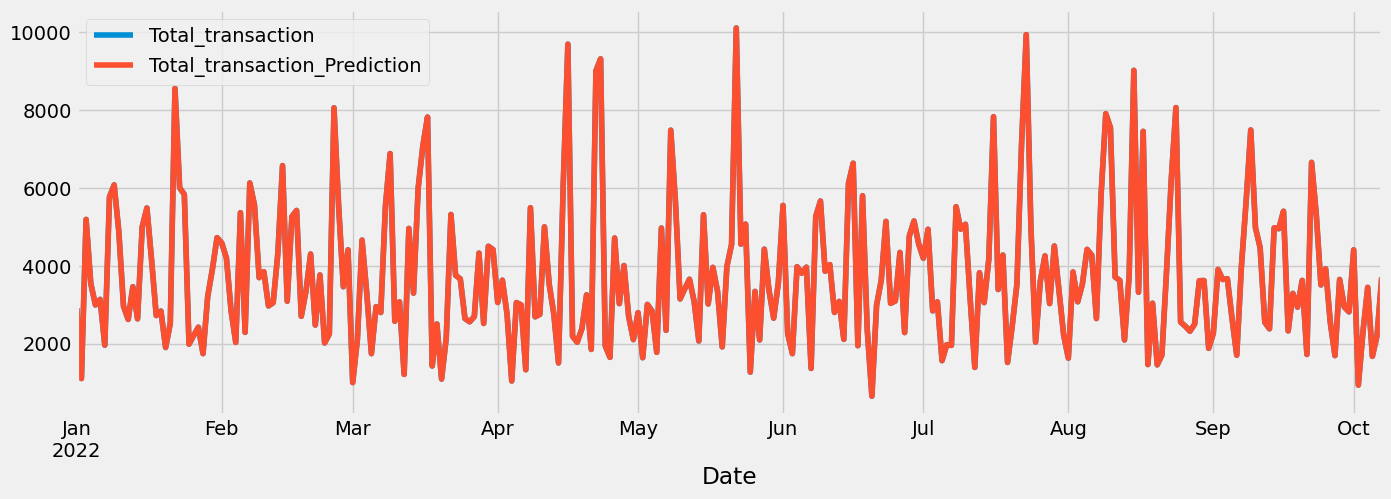

In [652]:
df_train['Total_transaction_Prediction'] = model.predict(X_train)

df_train[['Total_transaction','Total_transaction_Prediction']].plot(figsize=(15, 5))

The blue curve (**Predictions**) is almost not visible because of the perfect similarity with the orange one (**Real values**).<br>
The training set learned perfectly to predict the values. But is it good learning or overfitting? Let;s see what happens in the testing set.

In [654]:
df_test['Forecast_XGBoost'] = model.predict(X_test)

overall_data = pd.concat([df_train, df_test], sort=False)

<AxesSubplot:xlabel='Date'>

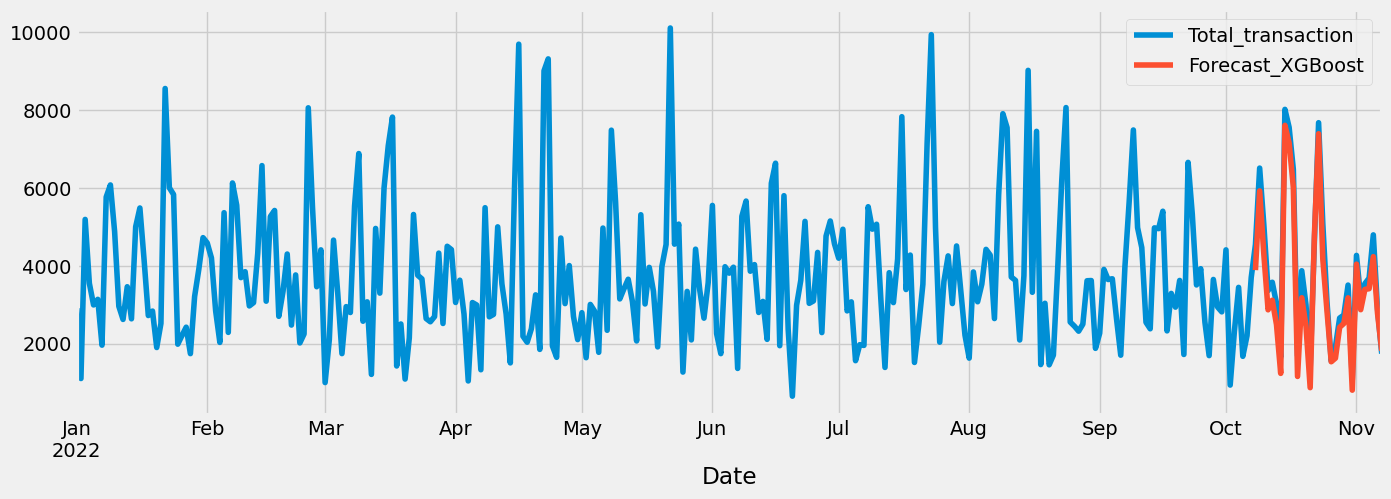

In [655]:
overall_data[['Total_transaction','Forecast_XGBoost']].plot(figsize=(15, 5))

Seems like it's a quite good learning after all.

<AxesSubplot:xlabel='Date'>

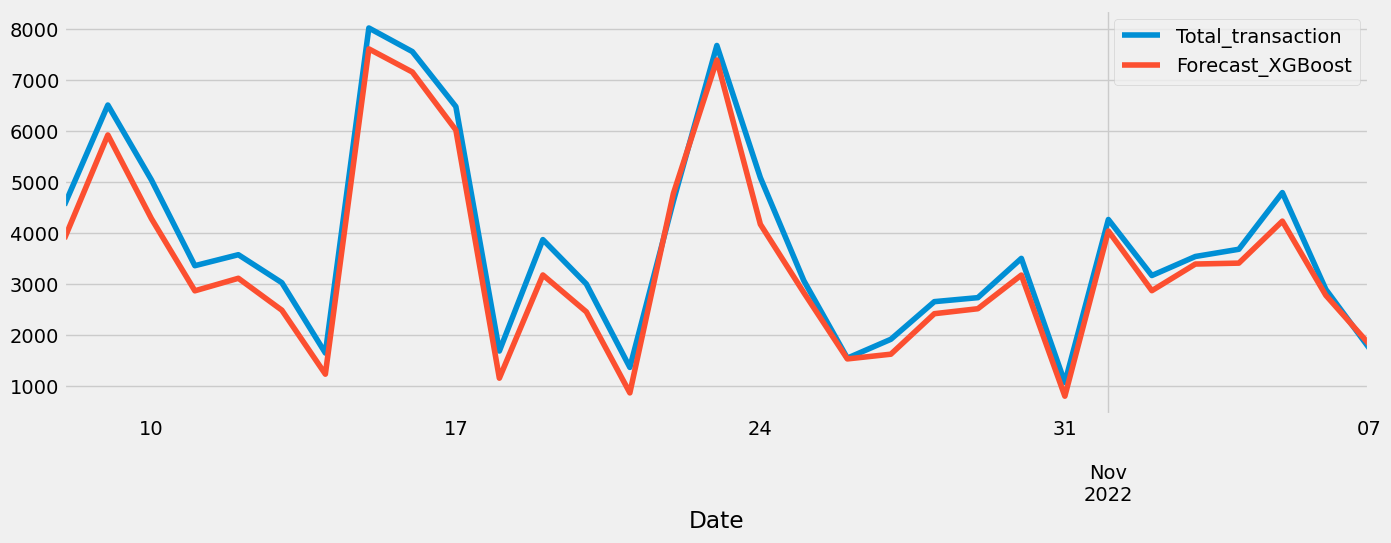

In [656]:
df_test[['Total_transaction','Forecast_XGBoost']].plot(figsize=(15, 5))

In [657]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

train_mae = mean_absolute_error(df_train['Total_transaction'], df_train['Total_transaction_Prediction'])
train_rmse = np.sqrt(mean_squared_error(df_train['Total_transaction'], df_train['Total_transaction_Prediction']))
train_r2 = r2_score(df_train['Total_transaction'], df_train['Total_transaction_Prediction'])

print(f"train MAE : {train_mae}")
print(f"train RMSE : {train_rmse}")
print(f"train R2 : {train_r2}")

train MAE : 0.24034293038505603
train RMSE : 0.3044721152041997
train R2 : 0.9999999708225314


In [658]:
test_mae = mean_absolute_error(df_test['Total_transaction'], df_test['Forecast_XGBoost'])
test_rmse = np.sqrt(mean_squared_error(df_test['Total_transaction'], df_test['Forecast_XGBoost']))
test_r2 = r2_score(df_test['Total_transaction'], df_test['Forecast_XGBoost'])

print(f"test MAE : {test_mae}")
print(f"test RMSE : {test_rmse}")
print(f"test R2 : {test_r2}")

test MAE : 390.01420827557956
test RMSE : 442.0304478866204
test R2 : 0.9441379516780326


The RMSE is 442 on a scale of +10000.
The R2 score is 94%.

### Can we improve the score?

Basic features which are **Date** and **Transaction amount** gave us a relatively good score of 94%. I believe this could be improved using the other features from **category**.

## EDA, FEATURE ENGINEERING & PRE-PROCESSING

In [804]:
df.head()

,Date,Id_compte,amount_transaction,category_transaction,category
0,2022-01-01,SEWC_CL.1,462.96,Food & Drink - Groceries,Food & Drinks
1,2022-01-01,SEW0C_LI.1,15.51,General Services - Home Repair + Maintenance,General
2,2022-01-01,US.1,2.24,Bank Transfers - ATM withdrawals,Bank Transfers
3,2022-01-01,TA.1,2.86,Transportation - Public Transport,Food & Drinks
4,2022-01-01,US.1,1.68,Bank Transfers - ATM withdrawals,Bank Transfers


In [704]:
df.category_transaction.value_counts().head()

Bank Transfers - ATM fees            3729
Transportation - Public Transport    3102
Transportation - Parking             2569
Bank Transfers - ATM withdrawals     2195
Food & Drink - Coffee and tea        2163
Name: category_transaction, dtype: int64

In [705]:
df['category_transaction'].value_counts().count()

68

68 values is too much to encode, let's try to minimize the number.

In [706]:
df['category'] = df['category_transaction'].str.split('-').str[0]
df.head()

,Date,Id_compte,amount_transaction,category_transaction,category
0,2022-01-01 00:23:00,SEWC_CL.1,462.96,Food & Drink - Groceries,Food & Drink
1,2022-01-01 00:26:00,SEW0C_LI.1,15.51,General Services - Home Repair + Maintenance,General Services
2,2022-01-01 01:01:00,US.1,2.24,Bank Transfers - ATM withdrawals,Bank Transfers
3,2022-01-01 01:21:00,TA.1,2.86,Transportation - Public Transport,Transportation
4,2022-01-01 01:54:00,US.1,1.68,Bank Transfers - ATM withdrawals,Bank Transfers


In [707]:
df['category'].value_counts().count()

20

This is better, but still can be minimized!

In [708]:
df.category.value_counts()

Bank Transfers           7077
Transportation           6361
Food & Drink             4126
Medical                   577
General Merchandise       437
Transportation            398
General Services          359
Rent & Utilities          308
Entertainment             228
Supermarkets              164
Subscription              113
Travel                     56
Loans                      55
General Services           36
Income                     33
General Merchandise        31
Entertainment              27
Government + Non           11
Credit card payment         7
Travel                      7
Name: category, dtype: int64

We notice that there are some values that are repetitive while there is no apparent difference. Why?<br>
Surely the blank spaces!

In [726]:
df.category.unique()

array(['Food & Drink ', 'General Services ', 'Bank Transfers ',
       'Transportation ', 'Subscription ', 'Medical ',
       'Rent & Utilities ', 'General Services  ', 'Transportation',
       'Supermarkets ', 'Entertainment ', 'Loans ',
       'General Merchandise  ', 'General Merchandise ', 'Income ',
       'Travel ', 'Government + Non', 'Credit card payment', 'Travel  ',
       'Entertainment  '], dtype=object)

As expected, there are blank spaces in our category names. Let's display them in the dataset to have a better idea of how we can handle them.

In [721]:
df[df['category'] == 'Medical '].head()

,Date,Id_compte,amount_transaction,category_transaction,category
2056,2022-02-02 00:37:00,SEW0C_LI.1,310.2,Credit card payment,Credit card payment
6463,2022-04-09 09:42:00,SEW0C_LI.1,465.3,Credit card payment,Credit card payment
10952,2022-06-16 09:47:00,SEW0C_LI.1,310.2,Credit card payment,Credit card payment
13424,2022-07-23 21:55:00,SEW0C_LI.1,465.3,Credit card payment,Credit card payment
15716,2022-08-28 05:02:00,SEW0C_LI.1,155.1,Credit card payment,Credit card payment


In [720]:
df[df['category'] == 'Government + Non'].head()

,Date,Id_compte,amount_transaction,category_transaction,category
1115,2022-01-18 07:32:00,IPA.1,668.4,Government + Non-Profit - Taxes,Government + Non
2297,2022-02-05 21:37:00,CPA.1,1410.6,Government + Non-Profit - Other donations,Government + Non
5877,2022-03-31 17:20:00,SEWC_CL.1,385.8,Government + Non-Profit - Taxes,Government + Non
7989,2022-05-02 04:17:00,CPA.1,1410.6,Government + Non-Profit - Political donations,Government + Non
9259,2022-05-22 01:12:00,IPA.1,1336.8,Government + Non-Profit - Other donations,Government + Non


We can for example group transaction categories to limit the labels.<br>
**Example** : Daily depenses > Food & Drink, Supermarkets etc..

In [740]:
entertain_cat = ['Travel  ', 'Travel ', 'Entertainment','Entertainment ', 'Entertainment  ']
entertain_val = 'Entertainment'

daily_cat = ['Food & Drink', 'Supermarkets', 'Supermarkets ', 'Food & Drink ', 'Transportation','Transportation ']
daily_val = 'Food & Drinks'

fix_charges_cat = ['Subscription ', 'Loans ', 'Rent & Utilities ']
fixcharges_val = 'Fix Charges'

general_cat = ['General Merchandise  ', 'General Merchandise ', 'General Services ', 'General Services  ']
general_val = 'General'


df['category'] = df['category'].replace(entertain_cat, entertain_val)
df['category'] = df['category'].replace(daily_cat, daily_val)
df['category'] = df['category'].replace(fix_charges_cat, fixcharges_val)
df['category'] = df['category'].replace(general_cat, general_val)
df['category'] = df['category'].replace('Income ', 'Income')
df['category'] = df['category'].replace('Government + Non', 'Taxes/Donations')
df['category'] = df['category'].replace('Bank Transfers ', 'Bank Transfers')
df['category'] = df['category'].replace('Credit card payment', 'CC payment')
df['category'] = df['category'].replace('Medical ', 'Medical')

In [741]:
df.category.unique()

array(['Food & Drinks', 'General', 'Bank Transfers', 'Fix Charges',
       'Medical', 'Entertainment', 'Income', 'Taxes/Donations',
       'CC payment'], dtype=object)

In [742]:
df['category'].value_counts().count()

9

They can still be grouped to 3 classes for example , but I think 9 is okay, so that if there is any correlation between the category and the amount, we know exactly which one.

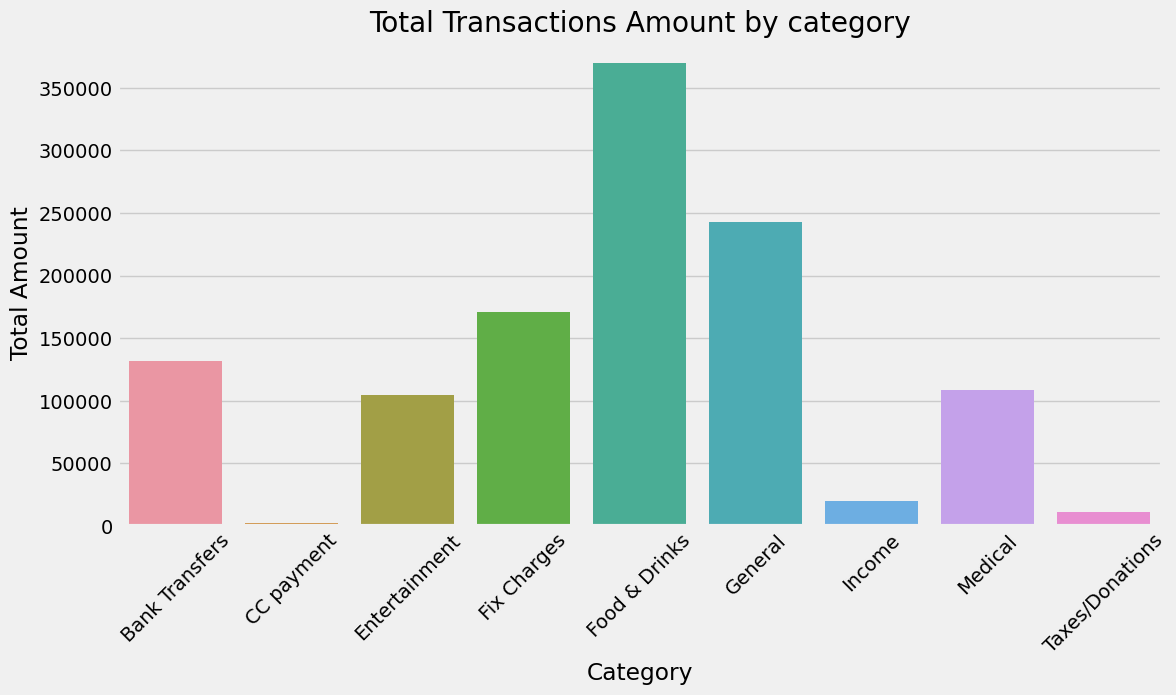

In [749]:
total_amount_by_cat = df.groupby("category")["amount_transaction"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='amount_transaction', data=total_amount_by_cat)  
plt.title('Total Transactions Amount by category')
plt.xlabel('Category')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.show()

### Visualize different transaction categories in different months and seasons 

#### Summer

In [757]:
#df['Date'] = pd.to_datetime(df['Date'])
categories_to_plot = ['Food & Drinks', 'General', 'Bank Transfers', 'Fix Charges', 'Medical', 'Entertainment', 'Income',
                      'Taxes/Donations','CC payment']


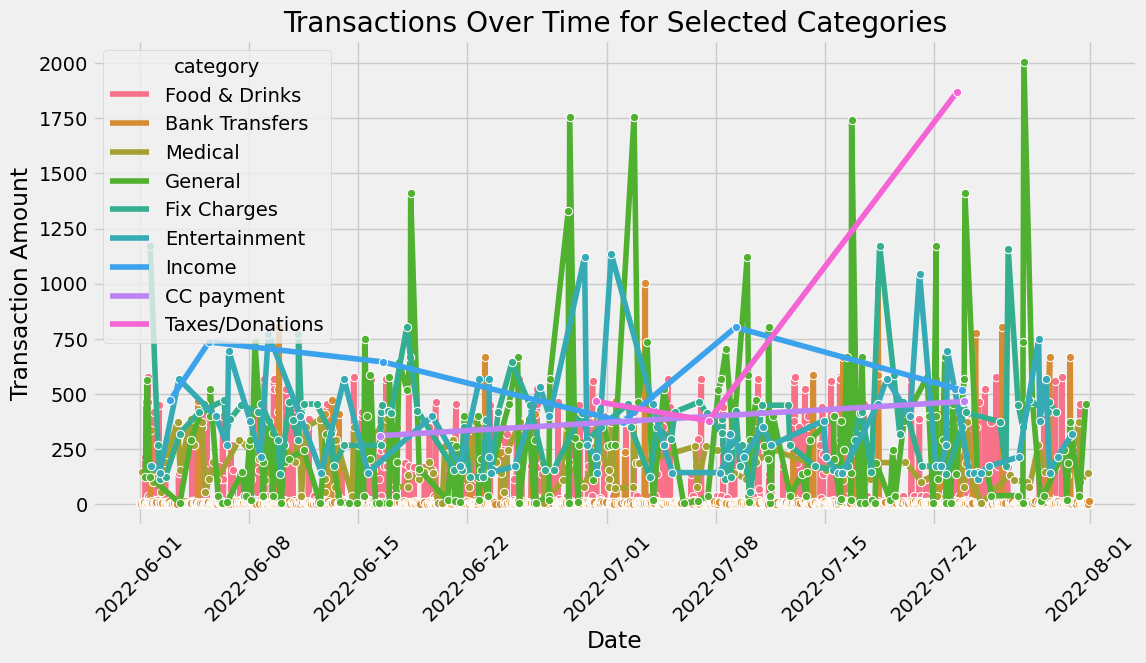

In [771]:
months_to_plot = [6,7]

# Filtrer les données pour les catégories et les mois spécifiés
filtered_data = df[(df['category'].isin(categories_to_plot)) & (df['Date'].dt.month.isin(months_to_plot))]

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='amount_transaction', hue='category', data=filtered_data, marker='o')
plt.title('Transactions Over Time for Selected Categories')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.show()

#### Winter

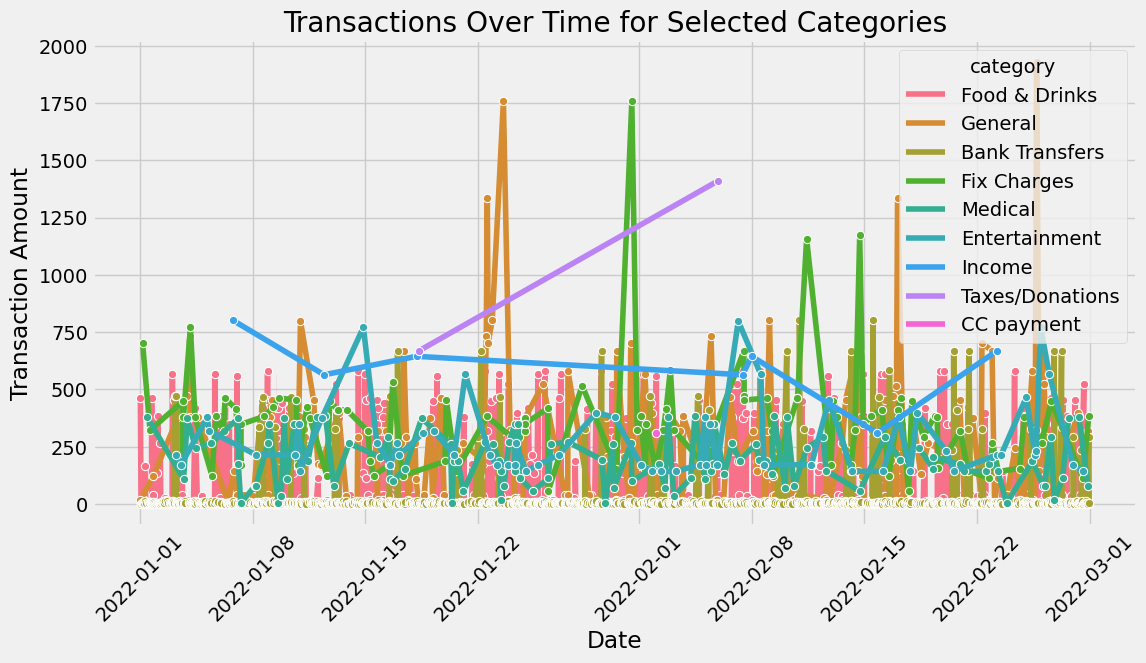

In [772]:
months_to_plot = [1,2]

# Filtrer les données pour les catégories et les mois spécifiés
filtered_data = df[(df['category'].isin(categories_to_plot)) & (df['Date'].dt.month.isin(months_to_plot))]

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='amount_transaction', hue='category', data=filtered_data, marker='o')
plt.title('Transactions Over Time for Selected Categories')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45)
plt.show()

In [796]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
Nbr_transactions = df.groupby(['Date','category'])['amount_transaction'].count().reset_index()
Total_transactions= df.groupby(['Date','category'])['amount_transaction'].sum().reset_index()

#merge the two columns in one new dataframe and rename columns
cat_df = pd.merge(Nbr_transactions, Total_transactions, on=['Date','category'])
cat_df.rename(columns={'amount_transaction_x': 'Nbr_transaction', 'amount_transaction_y': 'Total_transaction'}, inplace=True)
cat_df.head(1)
cat_df.head()

,Date,category,Nbr_transaction,Total_transaction
0,2022-01-01,Bank Transfers,24,128.71
1,2022-01-01,Fix Charges,2,1025.41
2,2022-01-01,Food & Drinks,30,1236.38
3,2022-01-01,General,2,138.82
4,2022-01-01,Medical,1,378.00


In [797]:
cat_df['Date'] = pd.to_datetime(cat_df['Date'])
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1655 entries, 0 to 1654
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1655 non-null   datetime64[ns]
 1   category           1655 non-null   object        
 2   Nbr_transaction    1655 non-null   int64         
 3   Total_transaction  1655 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 64.6+ KB


Next. we'll apply the same pre-processing methods we applied on the previous XGBoost model's data and see if it improves the accuracy.